# Model training

For this demo we'll use the freely available Statlog (German Credit Data) Data Set, which can be downloaded from [Kaggle](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)). This dataset classifies customers based on a set of attributes into two credit risk groups - good or bad. The majority of the attributes in this data set are categorical, and they are symbolically encoded. For example, attribute 1 represents the status of an existing checking account and can take one of the following values:

A11 : ... < 0 DM

A12 : 0 <= ... < 200 DM

A13 : ... >= 200 DM / salary assignments for at least 1 year

A14 : no checking account

A comprehensive list of all attributes and symbol codes is given in the [document](https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc) that accompanies the original dataset. 

The data we use in this demo has also been balanced and upsampled (see the [Data Generation](./data_generation.ipynb) notebook for reference).

## Seting up and connecting to Ray


Let's start by loading all the libraries needed for the notebook and by setting up default data paths.


In [1]:
import os
import ray
import glob
import eli5

import xgboost_ray as xgbr
import xgboost as xgb
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from ray import tune

DATA_ROOT = os.path.join("/mnt/data", os.environ["DOMINO_PROJECT_NAME"], "data") 
MODEL_ROOT = "/mnt/artifacts"
TUNE_ROOT = os.path.join("/mnt/data", os.environ["DOMINO_PROJECT_NAME"], "ray_results")

In this demo we'll use a dataset of a modest size (approx. 700 MB). Unfortunately, the standard Python libraries for data processing and machine learning Pandas and NumPy have never been designed with large datasets in mind. They rely on being able to fit the entire data in-memory with Pandas data frames having a hard theoretical limit of 100GB. In practice, the amount of data these libraries can handle is also restricted by the amount of physical memory available to the container that runs them, thus they'll have challenges handling even the 700 MB needed for our demo dataset. Trying to load our training data into a simple Pandas data frame using the code below will likely crash the Jupyter kernel.

``` 
# Do not run this code - it will likely crash the Jupyter kernel 
# (depending on the HW tier running the kernel)

import pandas as pd
import glob
import os

all_files = glob.glob(DATA_ROOT + "/train_data_*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

training_df = pd.concat(li, axis=0, ignore_index=True)
training_df.head()
```

To circumvent these restrictions Domino provides support for a number of industry-standard distributed computing frameworks like Ray, Dask, and Spark. In this demo we will use [On-Demand Ray](https://docs.dominodatalab.com/en/latest/user_guide/d13903/on-demand-ray-overview/). 

Ray is a general framework that enables you to quickly parallelize existing Python code, but it is also talked about as a "framework for building frameworks". Indeed, there are a growing number of domain-specific libraries that work on top of Ray.

![Ray](./images/ray.png)

For example:

* RaySGD - a library for distributed deep learning, which provides wrappers around PyTorch and TensorFlow
* RLlib - a library for reinforcement learning, which also natively supports TensorFlow, TensorFlow Eager, and PyTorch
* RayServe - a scalable, model-serving library
* Ray Tune - a hyperparameter optimization framework, most commonly used for deep and reinforcement learning

In this demo we'll use [Ray Tune](https://docs.ray.io/en/latest/tune/index.html) for hyperparameter optimisation and [XGBoost on Ray](https://github.com/ray-project/xgboost_ray) for model training.

In [2]:
# We'll set up Ray for 2 workers, 4 CPUs each (12 CPUs in total, counting the head node).

RAY_ACTORS = 3
RAY_CPUS_PER_ACTOR = 4

Let's connect to Ray.

In [3]:
if ray.is_initialized() == False:
    service_host = os.environ["RAY_HEAD_SERVICE_HOST"]
    service_port = os.environ["RAY_HEAD_SERVICE_PORT"]
    ray.init(f"ray://{service_host}:{service_port}")

Let's confirm we have the expected cluster configuration.

In [4]:
ray.nodes()

[{'NodeID': '62a4bc63e74c636944f6d8582793a41f61a1ef6a84f3c670ed41d64c',
  'Alive': True,
  'NodeManagerAddress': '100.64.16.212',
  'NodeManagerHostname': 'ray-6708586c414ea27ec5f7e3bd-ray-worker-2',
  'NodeManagerPort': 2385,
  'ObjectManagerPort': 2384,
  'ObjectStoreSocketName': '/tmp/ray/session_2024-10-10_15-45-01_529432_1/sockets/plasma_store',
  'RayletSocketName': '/tmp/ray/session_2024-10-10_15-45-01_529432_1/sockets/raylet',
  'MetricsExportPort': 53152,
  'NodeName': '100.64.16.212',
  'alive': True,
  'Resources': {'memory': 11203767501.0,
   'object_store_memory': 4801614643.0,
   'CPU': 4.0,
   'node:100.64.16.212': 1.0}},
 {'NodeID': '2ddee59a4a505e73a438c6d43253c4892dcecb39db0ccd3e934448e2',
  'Alive': True,
  'NodeManagerAddress': '100.64.88.115',
  'NodeManagerHostname': 'ray-6708586c414ea27ec5f7e3bd-ray-head-0',
  'NodeManagerPort': 2385,
  'ObjectManagerPort': 2384,
  'ObjectStoreSocketName': '/tmp/ray/session_2024-10-10_15-45-01_529432_1/sockets/plasma_store',
  'R

Now let's create a list of all the shards for our training, validation, and test sets.

In [5]:
train_files = glob.glob(os.path.join(DATA_ROOT, "train_data*"))
val_files = glob.glob(os.path.join(DATA_ROOT, "validation_data*"))

test_file = os.path.join(DATA_ROOT, "test_data.csv")

target_col = "credit"

XGBoost-Ray provides a drop-in replacement for XGBoost's train function. To pass data, instead of using xgb.DMatrix we will have to use xgboost_ray.RayDMatrix. The RayDMatrix lazy loads data and stores it sharded in the Ray object store. The Ray XGBoost actors then access these shards to run their training on. Let's wrap our training, validation, and test sets into RayDMatrix objects.

In [6]:
# Although it is possible to specify the number of Actors when initializing the RayDMatrix, it is not necessary,
#  and can cause a conflict if different from the number of Actors chosen for training.

rdm_train = xgbr.RayDMatrix(train_files, label=target_col)
rdm_val = xgbr.RayDMatrix(val_files, label=target_col)

df_test = pd.read_csv(test_file)
rdm_test = xgbr.RayDMatrix(df_test, label=target_col)

In [7]:
# This function verifies whether the data will support splitting into a given number of shards.
# We use this to validate that our splits are compatible with the selected Ray cluster configuraiton (i.e. number of Ray nodes)

rdm_train.assert_enough_shards_for_actors(len(train_files))
rdm_train.assert_enough_shards_for_actors(len(val_files))

In [8]:
print("Will the read be distributed?", rdm_train.distributed)
print("Has any data been read yet?", rdm_train.loaded) # Remember, lazy loading

Will the read be distributed? True
Has any data been read yet? False


## Model training

Let's first try to train a single model in order to validate our setup. Feel free to switch to the Ray Web UI tab and observe the distribution of workload among the individual Ray nodes.

A few things to note:

* We are using “binary:logistic” – logistic regression for binary classification (*credit* is in {0,1}), which outputs probability
* We are calculating both logloss and error as evaluation metrics. They don't impact the model fitting
* We are passing the cluster topology via the xgb_ray_params objects so that the workload can be correctly distributed


In [9]:
# Set a few hyperparameters to specific values
param = {
    "seed":1234,
    "max_depth":3,
    "eta":0.1,
    "objective": "binary:logistic",
    "eval_metric": ["logloss", "error"]
}

xgb_ray_params = xgbr.RayParams(
    num_actors=RAY_ACTORS,
    cpus_per_actor=RAY_CPUS_PER_ACTOR
)

# Train the model
evals_result = {}

bst = xgbr.train(
    param,
    rdm_train,
    num_boost_round=50,
    verbose_eval=True,
    evals_result=evals_result,
    evals =[(rdm_train, "train"), (rdm_val, "val")],
    ray_params=xgb_ray_params
)

print("Final training error: {:.4f}".format(evals_result["train"]["error"][-1]))
print("Final validation error: {:.4f}".format(evals_result["val"]["error"][-1]))

/opt/conda/lib/python3.9/site-packages/xgboost_ray/util.py:89: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
Use get_node_id() instead
  current_node_id = ray.get_runtime_context().node_id.hex()
(_wrapped pid=462) 2024-10-10 15:54:10,991	INFO main.py:1047 -- [RayXGBoost] Created 3 new actors (3 total actors). Waiting until actors are ready for training.
(_wrapped pid=462) 2024-10-10 15:54:19,564	INFO main.py:1092 -- [RayXGBoost] Starting XGBoost training.
(_RemoteRayXGBoostActor pid=173, ip=100.64.16.212) [15:54:19] task [xgboost.ray]:124244306752608 got new rank 0
(_RemoteRayXGBoostActor pid=173, ip=100.64.28.180) [15:54:19] task [xgboost.ray]:130766275778400 got new rank 1
(_RemoteRayXGBoostActor pid=213, ip=100.64.40.251) [15:54:19] task [xgboost.ray]:137014653312976 got new rank 2


(_wrapped pid=462) [0]	train-logloss:0.65893	train-error:0.22747	val-logloss:0.65632	val-error:0.20883
(_wrapped pid=462) [1]	train-logloss:0.63107	train-error:0.22322	val-logloss:0.62528	val-error:0.20100
(_wrapped pid=462) [2]	train-logloss:0.60867	train-error:0.22340	val-logloss:0.60093	val-error:0.21037
(_wrapped pid=462) [3]	train-logloss:0.58682	train-error:0.18661	val-logloss:0.57685	val-error:0.15869
(_wrapped pid=462) [4]	train-logloss:0.56887	train-error:0.19067	val-logloss:0.55652	val-error:0.16575
(_wrapped pid=462) [5]	train-logloss:0.55208	train-error:0.20116	val-logloss:0.53918	val-error:0.17895
(_wrapped pid=462) [6]	train-logloss:0.53641	train-error:0.18801	val-logloss:0.52260	val-error:0.16270
(_wrapped pid=462) [7]	train-logloss:0.52349	train-error:0.18786	val-logloss:0.50925	val-error:0.16583
(_wrapped pid=462) [8]	train-logloss:0.51107	train-error:0.17899	val-logloss:0.49675	val-error:0.15643
(_wrapped pid=462) [9]	train-logloss:0.50011	train-error:0.17010	val-logl

(_wrapped pid=462) 2024-10-10 15:54:49,958	INFO main.py:1175 -- Training in progress (30 seconds since last restart).


(_wrapped pid=462) [33]	train-logloss:0.34933	train-error:0.11958	val-logloss:0.33443	val-error:0.11191
(_wrapped pid=462) [34]	train-logloss:0.34567	train-error:0.11774	val-logloss:0.33072	val-error:0.11112
(_wrapped pid=462) [35]	train-logloss:0.34235	train-error:0.11425	val-logloss:0.32712	val-error:0.10569
(_wrapped pid=462) [36]	train-logloss:0.33930	train-error:0.11425	val-logloss:0.32434	val-error:0.10485
(_wrapped pid=462) [37]	train-logloss:0.33627	train-error:0.11378	val-logloss:0.32137	val-error:0.10168
(_wrapped pid=462) [38]	train-logloss:0.33369	train-error:0.11401	val-logloss:0.31905	val-error:0.10329
(_wrapped pid=462) [39]	train-logloss:0.33074	train-error:0.11223	val-logloss:0.31621	val-error:0.10096
(_wrapped pid=462) [40]	train-logloss:0.32727	train-error:0.11088	val-logloss:0.31177	val-error:0.10167
(_wrapped pid=462) [41]	train-logloss:0.32467	train-error:0.10659	val-logloss:0.30873	val-error:0.09542
(_wrapped pid=462) [42]	train-logloss:0.32279	train-error:0.1078

(_wrapped pid=462) 2024-10-10 15:55:03,035	INFO main.py:1587 -- [RayXGBoost] Finished XGBoost training on training data with total N=2,100,000 in 53.04 seconds (43.46 pure XGBoost training time).


Final training error: 0.0985
Final validation error: 0.0884


Now that we've confirmed the pipeline we can move onto performing some hyperparameter tuning for finding an optimal model.

## Hyperparameter tuning

Hyperparameter tuning requires training many copies of a model, each with a different set of hyperparameters, and seeing which one performs the best. Each time we train a model, that is one trial. To do this in our Ray cluster, we can specify what resources to use:

* Required CPU, Memory, and/or GPU per trial
* Where to store intermediate results

The `xgboost_ray` library includes a built-in method for generating a `PlacementGroupFactory` to pass to Ray Tune, based on the `RayParams` object used for XGBoost training. Resources can also be requested in a simpler dictionary format, e.g. `{"cpu": 2.0}`. As described in the [Tune docs](https://docs.ray.io/en/latest/tune/tutorials/tune-resources.html), by default Ray Tune will schedule N concurrent trials, using 1 CPU per trial, where N is the total number of CPUs available in the cluster.

In [10]:
# Get the placement group factory to pass to Ray Tune
# Notice how the tune resources are 1 CPU greater!
xgb_tune_resources = xgb_ray_params.get_tune_resources()
print(f"We will pass a {type(xgb_tune_resources)} to Ray Tune.")
print(f"It will request {xgb_tune_resources.required_resources} per trial.")
print(f"The cluster has {ray.cluster_resources()['CPU']} CPU total.")

We will pass a <class 'ray.tune.execution.placement_groups.PlacementGroupFactory'> to Ray Tune.
It will request {'CPU': 12.0} per trial.
The cluster has 12.0 CPU total.


In [11]:
print("Saving intermediate tune results to", TUNE_ROOT)

Saving intermediate tune results to /mnt/data/Demo-Credit-Default-Model/ray_results


In this demo we will use a very simple search strategy called *a grid search*. This involves searching over a predefined grid of hyperparameter choices - and it's easy to imaging writing a simple for loop to implement it. However, for $n$ choices each of $k$ hyperparameters, a full grid search requires $O(n^k)$ trials and quickly becomes prohibitively expensive.

Ray Tune provides much more sophisticated options for optimization. Instead of pre-defining a fixed grid to search over, Ray Tune allows specifying a [search space](https://docs.ray.io/en/releases-1.11.0/tune/key-concepts.html#search-spaces) with distributions of parameters. The number of trials over the search space is specified at a later stage in the `run()` function.

In [12]:
config = {
    "seed": 1234,
    "eta": tune.loguniform(3e-3, 3e-1),
    "max_depth": tune.randint(2, 6),
    "objective": "binary:logistic",
    "eval_metric": ["logloss", "error"]
}

For each trial, a config dictionary like the one we just defined, with the single value for each hyperparameter chosen for that trial, will be passed into a [trainable](https://docs.ray.io/en/releases-1.11.0/tune/key-concepts.html#search-algorithms) that we define and pass to Ray Tune. Below we have defined such a function to wrap training a single XGBoost model on Ray.

In [13]:
def my_trainer(config):
    evals_result = {}
    bst = xgbr.train(
        params=config,
        dtrain=rdm_train,
        num_boost_round=50,
        evals_result=evals_result,
        evals=[(rdm_train, "train"), (rdm_val, "val")],
        ray_params=xgb_ray_params
    )
    bst.save_model("model.xgb") # This will go into the TUNE_ROOT directory

Finally, we can now run our trials. Here we bring together the previous few sections:

* The training function
* The search space defined in the config
* The resources per trial and results location

We control the number of trials over the search space via the `num_samples` argument (currently set to 10). We also rank the models based on the lowest validation set error.

In [14]:
analysis = tune.run(
    my_trainer,
    config=config,
    resources_per_trial=xgb_tune_resources,
    local_dir=TUNE_ROOT,
    metric="val-error",
    mode="min",
    num_samples=10,
    verbose=1,
    progress_reporter=tune.JupyterNotebookReporter(overwrite=True)
)

(run pid=964) UserWarning: The `local_dir` argument of `Experiment is deprecated. Use `storage_path` or set the `TUNE_RESULT_DIR` environment variable instead.
(_RemoteRayXGBoostActor pid=253, ip=100.64.16.212) [16:04:11] task [xgboost.ray]:129169392002768 got new rank 0
(_RemoteRayXGBoostActor pid=256, ip=100.64.28.180) [16:04:11] task [xgboost.ray]:123867071473504 got new rank 1
(_RemoteRayXGBoostActor pid=296, ip=100.64.40.251) [16:04:11] task [xgboost.ray]:137906461333008 got new rank 2


(my_trainer pid=1425) [0]	train-logloss:0.61284	train-error:0.20572	val-logloss:0.60896	val-error:0.19872
(my_trainer pid=1425) [1]	train-logloss:0.55775	train-error:0.18171	val-logloss:0.54853	val-error:0.16744
(my_trainer pid=1425) [2]	train-logloss:0.51397	train-error:0.17053	val-logloss:0.50365	val-error:0.15813
(my_trainer pid=1425) [3]	train-logloss:0.47781	train-error:0.15624	val-logloss:0.46482	val-error:0.14155
(my_trainer pid=1425) [4]	train-logloss:0.44780	train-error:0.15248	val-logloss:0.43254	val-error:0.13462
(my_trainer pid=1425) [5]	train-logloss:0.42228	train-error:0.14164	val-logloss:0.40654	val-error:0.12915
(my_trainer pid=1425) [6]	train-logloss:0.40149	train-error:0.13655	val-logloss:0.38652	val-error:0.12599
(my_trainer pid=1425) [7]	train-logloss:0.38272	train-error:0.13825	val-logloss:0.36712	val-error:0.12604
(my_trainer pid=1425) [8]	train-logloss:0.36533	train-error:0.12096	val-logloss:0.35080	val-error:0.11277
(my_trainer pid=1425) [9]	train-logloss:0.3506

(my_trainer pid=1425) 2024-10-10 16:04:42,358	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=1425) [27]	train-logloss:0.21478	train-error:0.06358	val-logloss:0.20128	val-error:0.05561
(my_trainer pid=1425) [28]	train-logloss:0.21199	train-error:0.06210	val-logloss:0.19895	val-error:0.05403
(my_trainer pid=1425) [29]	train-logloss:0.20827	train-error:0.05512	val-logloss:0.19542	val-error:0.04544
(my_trainer pid=1425) [30]	train-logloss:0.20415	train-error:0.05296	val-logloss:0.19153	val-error:0.04466
(my_trainer pid=1425) [31]	train-logloss:0.20103	train-error:0.05388	val-logloss:0.18845	val-error:0.04778
(my_trainer pid=1425) [32]	train-logloss:0.19799	train-error:0.05353	val-logloss:0.18562	val-error:0.04699
(my_trainer pid=1425) [33]	train-logloss:0.19521	train-error:0.05422	val-logloss:0.18342	val-error:0.05091
(my_trainer pid=1425) [34]	train-logloss:0.19242	train-error:0.05432	val-logloss:0.18073	val-error:0.05012
(my_trainer pid=1425) [35]	train-logloss:0.18819	train-error:0.05036	val-logloss:0.17667	val-error:0.04384
(my_trainer pid=1425) [36]	train-logl

(_RemoteRayXGBoostActor pid=333, ip=100.64.16.212) [16:05:10] task [xgboost.ray]:128733959417808 got new rank 0
(_RemoteRayXGBoostActor pid=340, ip=100.64.28.180) [16:05:10] task [xgboost.ray]:133254783932160 got new rank 1
(_RemoteRayXGBoostActor pid=380, ip=100.64.40.251) [16:05:10] task [xgboost.ray]:130388290316080 got new rank 2


(my_trainer pid=1425) [0]	train-logloss:0.67621	train-error:0.22747	val-logloss:0.67495	val-error:0.20883
(my_trainer pid=1425) [1]	train-logloss:0.66124	train-error:0.22322	val-logloss:0.65835	val-error:0.20100
(my_trainer pid=1425) [2]	train-logloss:0.64760	train-error:0.21105	val-logloss:0.64296	val-error:0.18852
(my_trainer pid=1425) [3]	train-logloss:0.63546	train-error:0.20920	val-logloss:0.62982	val-error:0.19554
(my_trainer pid=1425) [4]	train-logloss:0.62341	train-error:0.21349	val-logloss:0.61613	val-error:0.19787
(my_trainer pid=1425) [5]	train-logloss:0.61263	train-error:0.20704	val-logloss:0.60399	val-error:0.19162
(my_trainer pid=1425) [6]	train-logloss:0.60277	train-error:0.21146	val-logloss:0.59391	val-error:0.19224
(my_trainer pid=1425) [7]	train-logloss:0.59304	train-error:0.21123	val-logloss:0.58283	val-error:0.19300
(my_trainer pid=1425) [8]	train-logloss:0.58328	train-error:0.20666	val-logloss:0.57256	val-error:0.18916
(my_trainer pid=1425) [9]	train-logloss:0.5750

(my_trainer pid=1425) 2024-10-10 16:05:40,741	INFO main.py:1175 -- Training in progress (30 seconds since last restart).


(my_trainer pid=1425) [26]	train-logloss:0.47452	train-error:0.16759	val-logloss:0.45954	val-error:0.15182
(my_trainer pid=1425) [27]	train-logloss:0.46997	train-error:0.16546	val-logloss:0.45503	val-error:0.14872
(my_trainer pid=1425) [28]	train-logloss:0.46555	train-error:0.16264	val-logloss:0.45110	val-error:0.14796
(my_trainer pid=1425) [29]	train-logloss:0.46130	train-error:0.16345	val-logloss:0.44700	val-error:0.14798
(my_trainer pid=1425) [30]	train-logloss:0.45739	train-error:0.15995	val-logloss:0.44317	val-error:0.14718
(my_trainer pid=1425) [31]	train-logloss:0.45407	train-error:0.15916	val-logloss:0.43983	val-error:0.14328
(my_trainer pid=1425) [32]	train-logloss:0.45028	train-error:0.15918	val-logloss:0.43651	val-error:0.14486
(my_trainer pid=1425) [33]	train-logloss:0.44612	train-error:0.15748	val-logloss:0.43203	val-error:0.14563
(my_trainer pid=1425) [34]	train-logloss:0.44266	train-error:0.15554	val-logloss:0.42840	val-error:0.14407
(my_trainer pid=1425) [35]	train-logl

(_RemoteRayXGBoostActor pid=415, ip=100.64.16.212) [16:06:11] task [xgboost.ray]:137786663410512 got new rank 0
(_RemoteRayXGBoostActor pid=465, ip=100.64.28.180) [16:06:11] task [xgboost.ray]:123147105264448 got new rank 1
(_RemoteRayXGBoostActor pid=501, ip=100.64.40.251) [16:06:11] task [xgboost.ray]:136722663795584 got new rank 2


(my_trainer pid=1425) [0]	train-logloss:0.69192	train-error:0.22747	val-logloss:0.69183	val-error:0.20883
(my_trainer pid=1425) [1]	train-logloss:0.69070	train-error:0.22747	val-logloss:0.69053	val-error:0.20883
(my_trainer pid=1425) [2]	train-logloss:0.68955	train-error:0.22331	val-logloss:0.68924	val-error:0.20021
(my_trainer pid=1425) [3]	train-logloss:0.68840	train-error:0.22331	val-logloss:0.68796	val-error:0.20021
(my_trainer pid=1425) [4]	train-logloss:0.68725	train-error:0.21506	val-logloss:0.68669	val-error:0.19317
(my_trainer pid=1425) [5]	train-logloss:0.68606	train-error:0.22331	val-logloss:0.68541	val-error:0.20021
(my_trainer pid=1425) [6]	train-logloss:0.68494	train-error:0.21506	val-logloss:0.68416	val-error:0.19317
(my_trainer pid=1425) [7]	train-logloss:0.68382	train-error:0.21506	val-logloss:0.68291	val-error:0.19317
(my_trainer pid=1425) [8]	train-logloss:0.68265	train-error:0.21506	val-logloss:0.68166	val-error:0.19317
(my_trainer pid=1425) [9]	train-logloss:0.6815

(my_trainer pid=1425) 2024-10-10 16:06:41,655	INFO main.py:1175 -- Training in progress (30 seconds since last restart).


(my_trainer pid=1425) [26]	train-logloss:0.66343	train-error:0.20924	val-logloss:0.66046	val-error:0.18772
(my_trainer pid=1425) [27]	train-logloss:0.66243	train-error:0.20924	val-logloss:0.65935	val-error:0.18772
(my_trainer pid=1425) [28]	train-logloss:0.66139	train-error:0.20924	val-logloss:0.65822	val-error:0.18772
(my_trainer pid=1425) [29]	train-logloss:0.66041	train-error:0.20924	val-logloss:0.65713	val-error:0.18772
(my_trainer pid=1425) [30]	train-logloss:0.65943	train-error:0.20924	val-logloss:0.65604	val-error:0.18772
(my_trainer pid=1425) [31]	train-logloss:0.65846	train-error:0.20924	val-logloss:0.65497	val-error:0.18772
(my_trainer pid=1425) [32]	train-logloss:0.65744	train-error:0.20924	val-logloss:0.65384	val-error:0.18772
(my_trainer pid=1425) [33]	train-logloss:0.65642	train-error:0.20924	val-logloss:0.65273	val-error:0.18772
(my_trainer pid=1425) [34]	train-logloss:0.65540	train-error:0.20924	val-logloss:0.65159	val-error:0.18772
(my_trainer pid=1425) [35]	train-logl

(_RemoteRayXGBoostActor pid=496, ip=100.64.16.212) [16:07:11] task [xgboost.ray]:132285973811152 got new rank 0
(_RemoteRayXGBoostActor pid=550, ip=100.64.28.180) [16:07:11] task [xgboost.ray]:133230083696336 got new rank 1
(_RemoteRayXGBoostActor pid=664, ip=100.64.40.251) [16:07:11] task [xgboost.ray]:123937397745504 got new rank 2


(my_trainer pid=1425) [0]	train-logloss:0.68161	train-error:0.16215	val-logloss:0.68140	val-error:0.16275
(my_trainer pid=1425) [1]	train-logloss:0.67081	train-error:0.15927	val-logloss:0.66988	val-error:0.14472
(my_trainer pid=1425) [2]	train-logloss:0.66042	train-error:0.15245	val-logloss:0.65871	val-error:0.13463
(my_trainer pid=1425) [3]	train-logloss:0.65032	train-error:0.14920	val-logloss:0.64784	val-error:0.13387
(my_trainer pid=1425) [4]	train-logloss:0.64031	train-error:0.14481	val-logloss:0.63767	val-error:0.12759
(my_trainer pid=1425) [5]	train-logloss:0.63069	train-error:0.14603	val-logloss:0.62758	val-error:0.13151
(my_trainer pid=1425) [6]	train-logloss:0.62170	train-error:0.14617	val-logloss:0.61799	val-error:0.12993
(my_trainer pid=1425) [7]	train-logloss:0.61269	train-error:0.14715	val-logloss:0.60855	val-error:0.12997
(my_trainer pid=1425) [8]	train-logloss:0.60429	train-error:0.14516	val-logloss:0.59938	val-error:0.12689
(my_trainer pid=1425) [9]	train-logloss:0.5959

(my_trainer pid=1425) 2024-10-10 16:07:42,186	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=1425) [25]	train-logloss:0.49297	train-error:0.12724	val-logloss:0.48247	val-error:0.11358
(my_trainer pid=1425) [26]	train-logloss:0.48730	train-error:0.12297	val-logloss:0.47686	val-error:0.10811
(my_trainer pid=1425) [27]	train-logloss:0.48210	train-error:0.12276	val-logloss:0.47141	val-error:0.10969
(my_trainer pid=1425) [28]	train-logloss:0.47676	train-error:0.12241	val-logloss:0.46598	val-error:0.10887
(my_trainer pid=1425) [29]	train-logloss:0.47179	train-error:0.11995	val-logloss:0.46087	val-error:0.10571
(my_trainer pid=1425) [30]	train-logloss:0.46665	train-error:0.11923	val-logloss:0.45565	val-error:0.10491
(my_trainer pid=1425) [31]	train-logloss:0.46177	train-error:0.11799	val-logloss:0.45059	val-error:0.10257
(my_trainer pid=1425) [32]	train-logloss:0.45733	train-error:0.11632	val-logloss:0.44603	val-error:0.10098
(my_trainer pid=1425) [33]	train-logloss:0.45262	train-error:0.11642	val-logloss:0.44114	val-error:0.10102
(my_trainer pid=1425) [34]	train-logl

(_RemoteRayXGBoostActor pid=615, ip=100.64.16.212) [16:08:13] task [xgboost.ray]:139111443981648 got new rank 0
(_RemoteRayXGBoostActor pid=677, ip=100.64.28.180) [16:08:13] task [xgboost.ray]:130415863139200 got new rank 1
(_RemoteRayXGBoostActor pid=744, ip=100.64.40.251) [16:08:13] task [xgboost.ray]:136691221190256 got new rank 2


(my_trainer pid=1425) [0]	train-logloss:0.68519	train-error:0.16215	val-logloss:0.68505	val-error:0.16275
(my_trainer pid=1425) [1]	train-logloss:0.67765	train-error:0.15994	val-logloss:0.67701	val-error:0.14472
(my_trainer pid=1425) [2]	train-logloss:0.67033	train-error:0.16447	val-logloss:0.66919	val-error:0.15181
(my_trainer pid=1425) [3]	train-logloss:0.66307	train-error:0.15046	val-logloss:0.66136	val-error:0.13387
(my_trainer pid=1425) [4]	train-logloss:0.65587	train-error:0.15533	val-logloss:0.65415	val-error:0.14316
(my_trainer pid=1425) [5]	train-logloss:0.64902	train-error:0.14982	val-logloss:0.64680	val-error:0.13699
(my_trainer pid=1425) [6]	train-logloss:0.64242	train-error:0.14716	val-logloss:0.63967	val-error:0.13308
(my_trainer pid=1425) [7]	train-logloss:0.63575	train-error:0.14759	val-logloss:0.63267	val-error:0.13231
(my_trainer pid=1425) [8]	train-logloss:0.62931	train-error:0.15144	val-logloss:0.62595	val-error:0.13304
(my_trainer pid=1425) [9]	train-logloss:0.6229

(my_trainer pid=1425) 2024-10-10 16:08:44,497	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=1425) [26]	train-logloss:0.53520	train-error:0.13463	val-logloss:0.52695	val-error:0.12295
(my_trainer pid=1425) [27]	train-logloss:0.53101	train-error:0.13617	val-logloss:0.52256	val-error:0.12605
(my_trainer pid=1425) [28]	train-logloss:0.52665	train-error:0.13419	val-logloss:0.51810	val-error:0.12296
(my_trainer pid=1425) [29]	train-logloss:0.52253	train-error:0.12937	val-logloss:0.51382	val-error:0.11748
(my_trainer pid=1425) [30]	train-logloss:0.51861	train-error:0.12925	val-logloss:0.50957	val-error:0.11748
(my_trainer pid=1425) [31]	train-logloss:0.51489	train-error:0.12914	val-logloss:0.50549	val-error:0.11672
(my_trainer pid=1425) [32]	train-logloss:0.51101	train-error:0.12767	val-logloss:0.50143	val-error:0.11590
(my_trainer pid=1425) [33]	train-logloss:0.50732	train-error:0.12949	val-logloss:0.49739	val-error:0.11668
(my_trainer pid=1425) [34]	train-logloss:0.50367	train-error:0.12701	val-logloss:0.49355	val-error:0.11513
(my_trainer pid=1425) [35]	train-logl

(_RemoteRayXGBoostActor pid=698, ip=100.64.16.212) [16:09:16] task [xgboost.ray]:131394884793872 got new rank 0
(_RemoteRayXGBoostActor pid=760, ip=100.64.28.180) [16:09:16] task [xgboost.ray]:128426608719280 got new rank 1
(_RemoteRayXGBoostActor pid=824, ip=100.64.40.251) [16:09:16] task [xgboost.ray]:125609654634288 got new rank 2


(my_trainer pid=1425) [0]	train-logloss:0.67328	train-error:0.30285	val-logloss:0.67211	val-error:0.29079
(my_trainer pid=1425) [1]	train-logloss:0.65597	train-error:0.26776	val-logloss:0.65341	val-error:0.24920
(my_trainer pid=1425) [2]	train-logloss:0.64117	train-error:0.27899	val-logloss:0.63725	val-error:0.26494
(my_trainer pid=1425) [3]	train-logloss:0.62693	train-error:0.26346	val-logloss:0.62176	val-error:0.24932
(my_trainer pid=1425) [4]	train-logloss:0.61468	train-error:0.25950	val-logloss:0.60919	val-error:0.24308
(my_trainer pid=1425) [5]	train-logloss:0.60328	train-error:0.25444	val-logloss:0.59680	val-error:0.23293
(my_trainer pid=1425) [6]	train-logloss:0.59294	train-error:0.24994	val-logloss:0.58535	val-error:0.23214
(my_trainer pid=1425) [7]	train-logloss:0.58290	train-error:0.24781	val-logloss:0.57547	val-error:0.22985
(my_trainer pid=1425) [8]	train-logloss:0.57414	train-error:0.24804	val-logloss:0.56596	val-error:0.23061
(my_trainer pid=1425) [9]	train-logloss:0.5660

(my_trainer pid=1425) 2024-10-10 16:09:46,933	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=1425) [28]	train-logloss:0.46088	train-error:0.18563	val-logloss:0.44951	val-error:0.17126
(my_trainer pid=1425) [29]	train-logloss:0.45720	train-error:0.18102	val-logloss:0.44556	val-error:0.16969
(my_trainer pid=1425) [30]	train-logloss:0.45386	train-error:0.17451	val-logloss:0.44265	val-error:0.16189
(my_trainer pid=1425) [31]	train-logloss:0.45083	train-error:0.17605	val-logloss:0.44024	val-error:0.16423
(my_trainer pid=1425) [32]	train-logloss:0.44727	train-error:0.17122	val-logloss:0.43633	val-error:0.15960
(my_trainer pid=1425) [33]	train-logloss:0.44403	train-error:0.17273	val-logloss:0.43292	val-error:0.16268
(my_trainer pid=1425) [34]	train-logloss:0.43974	train-error:0.16999	val-logloss:0.42795	val-error:0.15409
(my_trainer pid=1425) [35]	train-logloss:0.43720	train-error:0.17205	val-logloss:0.42514	val-error:0.16114
(my_trainer pid=1425) [36]	train-logloss:0.43371	train-error:0.17215	val-logloss:0.42138	val-error:0.15644
(my_trainer pid=1425) [37]	train-logl

(_RemoteRayXGBoostActor pid=821, ip=100.64.16.212) [16:10:15] task [xgboost.ray]:135061830505952 got new rank 0
(_RemoteRayXGBoostActor pid=844, ip=100.64.28.180) [16:10:15] task [xgboost.ray]:131237365155392 got new rank 1
(_RemoteRayXGBoostActor pid=907, ip=100.64.40.251) [16:10:15] task [xgboost.ray]:137167561227136 got new rank 2


(my_trainer pid=1425) [0]	train-logloss:0.62086	train-error:0.20572	val-logloss:0.61738	val-error:0.19872
(my_trainer pid=1425) [1]	train-logloss:0.56953	train-error:0.18171	val-logloss:0.56117	val-error:0.16744
(my_trainer pid=1425) [2]	train-logloss:0.52940	train-error:0.17572	val-logloss:0.51843	val-error:0.16042
(my_trainer pid=1425) [3]	train-logloss:0.49330	train-error:0.16470	val-logloss:0.48102	val-error:0.14542
(my_trainer pid=1425) [4]	train-logloss:0.46422	train-error:0.15256	val-logloss:0.45065	val-error:0.13219
(my_trainer pid=1425) [5]	train-logloss:0.43904	train-error:0.15059	val-logloss:0.42509	val-error:0.13303
(my_trainer pid=1425) [6]	train-logloss:0.41865	train-error:0.13227	val-logloss:0.40541	val-error:0.12053
(my_trainer pid=1425) [7]	train-logloss:0.40075	train-error:0.13213	val-logloss:0.38734	val-error:0.12051
(my_trainer pid=1425) [8]	train-logloss:0.38202	train-error:0.12548	val-logloss:0.37082	val-error:0.11581
(my_trainer pid=1425) [9]	train-logloss:0.3681

(my_trainer pid=1425) 2024-10-10 16:10:45,555	INFO main.py:1175 -- Training in progress (30 seconds since last restart).


(my_trainer pid=1425) [25]	train-logloss:0.23584	train-error:0.07246	val-logloss:0.22303	val-error:0.06578
(my_trainer pid=1425) [26]	train-logloss:0.23177	train-error:0.07157	val-logloss:0.21900	val-error:0.06575
(my_trainer pid=1425) [27]	train-logloss:0.22810	train-error:0.06629	val-logloss:0.21541	val-error:0.05874
(my_trainer pid=1425) [28]	train-logloss:0.22303	train-error:0.06162	val-logloss:0.21028	val-error:0.05480
(my_trainer pid=1425) [29]	train-logloss:0.21974	train-error:0.05972	val-logloss:0.20747	val-error:0.05324
(my_trainer pid=1425) [30]	train-logloss:0.21336	train-error:0.05795	val-logloss:0.20179	val-error:0.05245
(my_trainer pid=1425) [31]	train-logloss:0.20799	train-error:0.05850	val-logloss:0.19578	val-error:0.05007
(my_trainer pid=1425) [32]	train-logloss:0.20592	train-error:0.05746	val-logloss:0.19358	val-error:0.04773
(my_trainer pid=1425) [33]	train-logloss:0.20106	train-error:0.05590	val-logloss:0.18916	val-error:0.04696
(my_trainer pid=1425) [34]	train-logl

(_RemoteRayXGBoostActor pid=943, ip=100.64.16.212) [16:11:14] task [xgboost.ray]:138557833102960 got new rank 0
(_RemoteRayXGBoostActor pid=967, ip=100.64.28.180) [16:11:14] task [xgboost.ray]:124062953010512 got new rank 1
(_RemoteRayXGBoostActor pid=989, ip=100.64.40.251) [16:11:14] task [xgboost.ray]:138757711131984 got new rank 2


(my_trainer pid=1425) [0]	train-logloss:0.69207	train-error:0.22747	val-logloss:0.69199	val-error:0.20883
(my_trainer pid=1425) [1]	train-logloss:0.69099	train-error:0.22747	val-logloss:0.69084	val-error:0.20883
(my_trainer pid=1425) [2]	train-logloss:0.68997	train-error:0.22331	val-logloss:0.68970	val-error:0.20021
(my_trainer pid=1425) [3]	train-logloss:0.68896	train-error:0.22331	val-logloss:0.68858	val-error:0.20021
(my_trainer pid=1425) [4]	train-logloss:0.68790	train-error:0.22331	val-logloss:0.68744	val-error:0.20021
(my_trainer pid=1425) [5]	train-logloss:0.68690	train-error:0.22331	val-logloss:0.68632	val-error:0.20021
(my_trainer pid=1425) [6]	train-logloss:0.68590	train-error:0.21506	val-logloss:0.68521	val-error:0.19317
(my_trainer pid=1425) [7]	train-logloss:0.68491	train-error:0.21506	val-logloss:0.68411	val-error:0.19317
(my_trainer pid=1425) [8]	train-logloss:0.68387	train-error:0.21506	val-logloss:0.68300	val-error:0.19317
(my_trainer pid=1425) [9]	train-logloss:0.6828

(my_trainer pid=1425) 2024-10-10 16:11:44,758	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=1425) [33]	train-logloss:0.66049	train-error:0.20924	val-logloss:0.65721	val-error:0.18772
(my_trainer pid=1425) [34]	train-logloss:0.65963	train-error:0.20924	val-logloss:0.65625	val-error:0.18772
(my_trainer pid=1425) [35]	train-logloss:0.65872	train-error:0.20924	val-logloss:0.65527	val-error:0.18772
(my_trainer pid=1425) [36]	train-logloss:0.65781	train-error:0.20924	val-logloss:0.65428	val-error:0.18772
(my_trainer pid=1425) [37]	train-logloss:0.65691	train-error:0.20924	val-logloss:0.65329	val-error:0.18772
(my_trainer pid=1425) [38]	train-logloss:0.65602	train-error:0.20741	val-logloss:0.65231	val-error:0.18775
(my_trainer pid=1425) [39]	train-logloss:0.65518	train-error:0.20797	val-logloss:0.65138	val-error:0.18930
(my_trainer pid=1425) [40]	train-logloss:0.65437	train-error:0.20797	val-logloss:0.65050	val-error:0.18930
(my_trainer pid=1425) [41]	train-logloss:0.65354	train-error:0.20797	val-logloss:0.64958	val-error:0.18930
(my_trainer pid=1425) [42]	train-logl

(_RemoteRayXGBoostActor pid=1023, ip=100.64.16.212) [16:12:04] task [xgboost.ray]:136427654226944 got new rank 0
(_RemoteRayXGBoostActor pid=1089, ip=100.64.28.180) [16:12:04] task [xgboost.ray]:139623486051328 got new rank 1
(_RemoteRayXGBoostActor pid=1075, ip=100.64.40.251) [16:12:04] task [xgboost.ray]:131840366724864 got new rank 2


(my_trainer pid=1425) [0]	train-logloss:0.67310	train-error:0.16215	val-logloss:0.67275	val-error:0.16275
(my_trainer pid=1425) [1]	train-logloss:0.65489	train-error:0.15240	val-logloss:0.65319	val-error:0.13541
(my_trainer pid=1425) [2]	train-logloss:0.63778	train-error:0.14863	val-logloss:0.63498	val-error:0.13150
(my_trainer pid=1425) [3]	train-logloss:0.62113	train-error:0.14632	val-logloss:0.61744	val-error:0.13076
(my_trainer pid=1425) [4]	train-logloss:0.60592	train-error:0.14659	val-logloss:0.60090	val-error:0.12837
(my_trainer pid=1425) [5]	train-logloss:0.59131	train-error:0.13566	val-logloss:0.58576	val-error:0.11981
(my_trainer pid=1425) [6]	train-logloss:0.57767	train-error:0.13664	val-logloss:0.57150	val-error:0.12053
(my_trainer pid=1425) [7]	train-logloss:0.56432	train-error:0.13734	val-logloss:0.55761	val-error:0.12375
(my_trainer pid=1425) [8]	train-logloss:0.55264	train-error:0.13757	val-logloss:0.54496	val-error:0.12451
(my_trainer pid=1425) [9]	train-logloss:0.5410

(my_trainer pid=1425) 2024-10-10 16:12:34,627	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=1425) [33]	train-logloss:0.36238	train-error:0.09478	val-logloss:0.34805	val-error:0.08144
(my_trainer pid=1425) [34]	train-logloss:0.35787	train-error:0.09230	val-logloss:0.34340	val-error:0.07830
(my_trainer pid=1425) [35]	train-logloss:0.35283	train-error:0.09117	val-logloss:0.33833	val-error:0.07830
(my_trainer pid=1425) [36]	train-logloss:0.34828	train-error:0.08904	val-logloss:0.33390	val-error:0.07596
(my_trainer pid=1425) [37]	train-logloss:0.34360	train-error:0.08734	val-logloss:0.32912	val-error:0.07361
(my_trainer pid=1425) [38]	train-logloss:0.33883	train-error:0.08418	val-logloss:0.32479	val-error:0.07282
(my_trainer pid=1425) [39]	train-logloss:0.33429	train-error:0.08418	val-logloss:0.32020	val-error:0.07282
(my_trainer pid=1425) [40]	train-logloss:0.33012	train-error:0.08530	val-logloss:0.31621	val-error:0.07440
(my_trainer pid=1425) [41]	train-logloss:0.32609	train-error:0.08429	val-logloss:0.31223	val-error:0.07205
(my_trainer pid=1425) [42]	train-logl

(_RemoteRayXGBoostActor pid=1104, ip=100.64.16.212) [16:12:54] task [xgboost.ray]:128208408243072 got new rank 0
(_RemoteRayXGBoostActor pid=1174, ip=100.64.28.180) [16:12:54] task [xgboost.ray]:124328678161280 got new rank 1
(_RemoteRayXGBoostActor pid=1198, ip=100.64.40.251) [16:12:54] task [xgboost.ray]:123544911143936 got new rank 2


(my_trainer pid=1425) [0]	train-logloss:0.63921	train-error:0.20572	val-logloss:0.63664	val-error:0.19872
(my_trainer pid=1425) [1]	train-logloss:0.59748	train-error:0.18354	val-logloss:0.59159	val-error:0.17135
(my_trainer pid=1425) [2]	train-logloss:0.56291	train-error:0.17624	val-logloss:0.55486	val-error:0.16121
(my_trainer pid=1425) [3]	train-logloss:0.53336	train-error:0.17111	val-logloss:0.52386	val-error:0.15650
(my_trainer pid=1425) [4]	train-logloss:0.50910	train-error:0.16936	val-logloss:0.49726	val-error:0.15258
(my_trainer pid=1425) [5]	train-logloss:0.48590	train-error:0.16495	val-logloss:0.47227	val-error:0.14244
(my_trainer pid=1425) [6]	train-logloss:0.46703	train-error:0.16116	val-logloss:0.45272	val-error:0.14160
(my_trainer pid=1425) [7]	train-logloss:0.44773	train-error:0.14591	val-logloss:0.43164	val-error:0.12521
(my_trainer pid=1425) [8]	train-logloss:0.43136	train-error:0.13907	val-logloss:0.41626	val-error:0.12218
(my_trainer pid=1425) [9]	train-logloss:0.4153

(my_trainer pid=1425) 2024-10-10 16:13:25,030	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=1425) [33]	train-logloss:0.24098	train-error:0.06378	val-logloss:0.22666	val-error:0.05480
(my_trainer pid=1425) [34]	train-logloss:0.23687	train-error:0.06290	val-logloss:0.22311	val-error:0.05404
(my_trainer pid=1425) [35]	train-logloss:0.23412	train-error:0.06264	val-logloss:0.22072	val-error:0.05637
(my_trainer pid=1425) [36]	train-logloss:0.22915	train-error:0.05725	val-logloss:0.21626	val-error:0.04779
(my_trainer pid=1425) [37]	train-logloss:0.22625	train-error:0.05420	val-logloss:0.21364	val-error:0.04386
(my_trainer pid=1425) [38]	train-logloss:0.22447	train-error:0.05524	val-logloss:0.21211	val-error:0.04700
(my_trainer pid=1425) [39]	train-logloss:0.22139	train-error:0.05375	val-logloss:0.20935	val-error:0.04386
(my_trainer pid=1425) [40]	train-logloss:0.21828	train-error:0.05622	val-logloss:0.20651	val-error:0.04935
(my_trainer pid=1425) [41]	train-logloss:0.21379	train-error:0.04878	val-logloss:0.20249	val-error:0.04229
(my_trainer pid=1425) [42]	train-logl

(run pid=964) 2024-10-10 16:13:38,155	INFO tune.py:945 -- Total run time: 589.76 seconds (574.83 seconds for the tuning loop).


Ray Tune returns an `ExperimentAnalysis` object which contains the results of the trials. We are only interested in its `best_config` property, which provides information on the best performing trial (according to our evaluation criteria).

In [15]:
analysis.best_config

{'seed': 1234,
 'eta': 0.20179776446902176,
 'max_depth': 4,
 'objective': 'binary:logistic',
 'eval_metric': ['logloss', 'error']}

We now have the hyperparameters (*depth* and *learing rate*) that produce the best model. Luckily, we don't have to use them to train it from scratch as our training function automatically persists each attempted model. All we need to do now is to move the already trained variant to `/mnt` and ignore the others. We'll name the selected model `tune_best.xgb`.

In [16]:
import shutil

shutil.copy(
    os.path.join(analysis.best_logdir, "model.xgb"),
    os.path.join(MODEL_ROOT, "tune_best.xgb")
)

'/mnt/artifacts/tune_best.xgb'

Recall, that the model was selected using a validation set. We don't know its actual generalisation capability until we measure it on the test set.
Let's go ahead and test how well it performs on unseen data. Note, that here we are also using Ray for the inference. This is not necessary. Later you will see that we can just unpickle the model and use standard XGBoost for the purposes of operationalisation.

In [17]:
# Inference using Ray

# Load the serialized model
bst = xgb.Booster(model_file=os.path.join(MODEL_ROOT, "tune_best.xgb"))


xgb_ray_params = xgbr.RayParams(
    num_actors=RAY_ACTORS,
    cpus_per_actor=RAY_CPUS_PER_ACTOR
)

# Make predictions on the test data
predictions = xgbr.predict(bst, rdm_test, ray_params=xgb_ray_params)
pred_class = (predictions > 0.5).astype("int") 
actuals = df_test[target_col]
print("Accuracy on test: {:.2f}".format(accuracy_score(pred_class, actuals)))

(predict pid=16696) 2024-10-10 16:14:48,411	INFO main.py:1632 -- [RayXGBoost] Created 3 remote actors.
(predict pid=16696) 2024-10-10 16:14:50,333	INFO main.py:1649 -- [RayXGBoost] Starting XGBoost prediction.


Accuracy on test: 0.71


In [18]:
list(predictions)

[0.59348303,
 0.9776164,
 0.23749563,
 0.9875706,
 0.97870654,
 0.72509223,
 0.5384879,
 0.7414213,
 0.88253015,
 0.7122149,
 0.87903076,
 0.3360536,
 0.71549696,
 0.93560296,
 0.2888616,
 0.25419348,
 0.9750938,
 0.57251924,
 0.9650186,
 0.8619054,
 0.4301103,
 0.97575366,
 0.41871968,
 0.98875904,
 0.7226062,
 0.9597223,
 0.28197196,
 0.3251896,
 0.8864182,
 0.46116135,
 0.95180386,
 0.48890576,
 0.48583058,
 0.83861053,
 0.8734443,
 0.45033187,
 0.99612445,
 0.97526157,
 0.64351475,
 0.95633847,
 0.34024647,
 0.9868563,
 0.38093597,
 0.19295418,
 0.8820899,
 0.59996873,
 0.9770453,
 0.92163265,
 0.6241469,
 0.97918963,
 0.91012377,
 0.98638666,
 0.7942908,
 0.9439853,
 0.9553518,
 0.049633246,
 0.9747956,
 0.8405959,
 0.8925916,
 0.98984003,
 0.60971814,
 0.8305228,
 0.48687473,
 0.23749563,
 0.82702404,
 0.7889979,
 0.86771876,
 0.28957638,
 0.10036471,
 0.5551775,
 0.9665509,
 0.52142024,
 0.7903553,
 0.9935719,
 0.82773995,
 0.8893714,
 0.39603612,
 0.2320192,
 0.91844296,
 0.938

## Model explainability

The interest in interpretation of machine learning has been rapidly accelerating in the last decade. This can be attributed to the popularity that machine learning algorithms, and more specifically deep learning, has been gaining in various domains.

According to Fox et al. (2017), the need for explainable AI is mainly motivated by the following three reasons:

* The need for **trust** - if a doctor is recommending a treatment protocol based on a prediction from a neural network, this doctor must have absolute trust in the network's capability. This trust must be paramount when human lives are at stake.
* The need for **interaction** - complex decision making systems often rely on Human–Autonomy Teaming (HAT), where the outcome is produced by joint efforts of one or more humans and one or more autonomous agents. This form of cooperation requires that the human operator is able to interact with the model for the purposes of better understanding or improving the automated recommendations.
* The need for **transparency** - if a network makes an inappropriate recommendation or disagrees with a human expert, its behaviour must be explainable. There should be mechanisms that allow us to inspect the inner workings of the model's decision making process and get insight on what this decision was based on.

In addition, regulators are introducing legal requirements around the use of automated decision making. For example, [article 22 of the General Data Protection Regulation](https://gdpr-info.eu/art-22-gdpr/) (GDPR) introduces the right of explanation - the power of an individual to demand an explanation on the reasons behind a model-based decision and to challenge the decision if it leads to a negative impact for the individual. The Defence Advanced Research Projects Agency (DARPA) in the US is supporting a major effort that seeks to facilitate AI explainability (see Turek, DARPA XAI).

In this section of the notebook, we'll look into interpreting the inner workings of the model to better understand the encoded inductive biases.

Let's begin by loading the model as a normal XGBoost model. We are no longer using Ray, as the model itself and the inference don't process large amounts of data.

We'll also run another accuracy calculation on the test set (this time using a pure Pandas data frame) and make sure that the numbers agree.

In [19]:
xgc = xgb.Booster(model_file=os.path.join(MODEL_ROOT, "tune_best.xgb"))
df_test_X = df_test.drop(target_col, axis=1)
xgtest = xgb.DMatrix(df_test_X)

predictions = xgc.predict(xgtest)

pred_class = (predictions > 0.5).astype("int") 
actuals = df_test[target_col]
print("Accuracy on test: {:.2f}".format(accuracy_score(pred_class, actuals)))

Accuracy on test: 0.71


Generally speaking, feature importance quantifies how useful each feature was in the construction of the model. We can interrogate a fitted XGBoost model on the feature importance and get the numbers for each one of the individual features.

Indirectly, this tells us how much each feature contributes to the model predictions. There is a method called `plot_importance`, which. plots the attribute importance based on the fitted trees. This method accepts an argument named `importance_type`, which takes one of the following values and controls how importance is calculated:

* gain --- average gain of splits which use the feature. When looking at two features, the one with the higher gain is more important for generating a prediction. Typically, Gain is the most relevant attribute to interpret the relative importance of each feature.
* weight --- number of times a feature appears in a tree. 
* cover --- average coverage of splits which use the feature where coverage is defined as the number of samples affected by the split. This basically gives us the relative number of observations related to a feature.

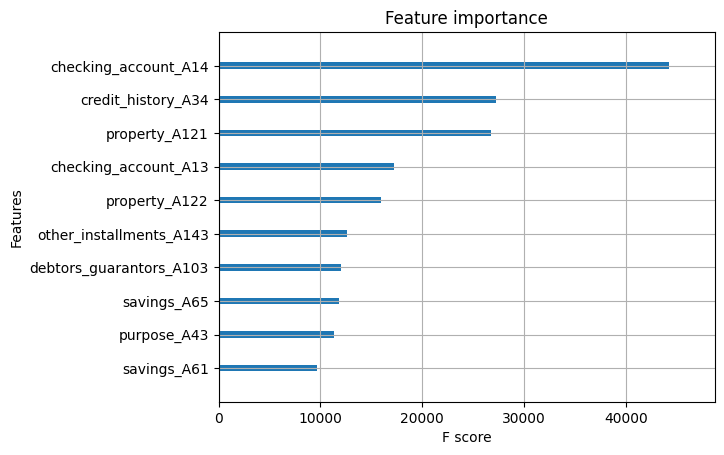

In [20]:
xgb.plot_importance(xgc, importance_type="gain", max_num_features=10, show_values=False);

Based on the above we see that the top three features driving the predictions of the model are:

* checking_account_A14 - lack of a checking account
* credit_history_A34 - critical account / has credits outside of the bank
* property_A121 - real estate

We could also look at the other importance metrics, just for completeness.

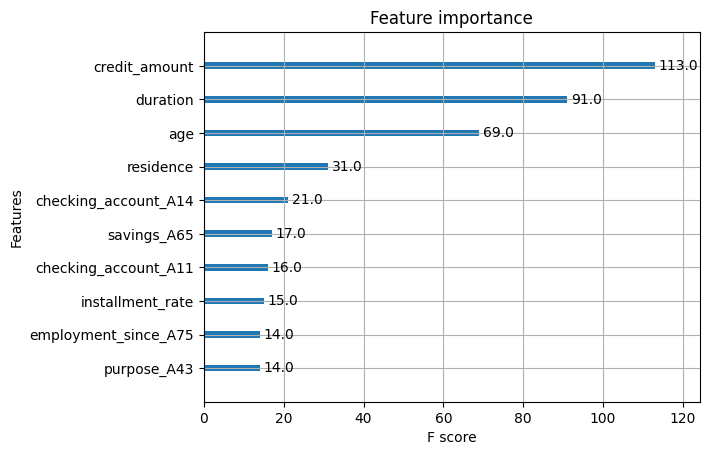

In [21]:
xgb.plot_importance(xgc, importance_type="weight", max_num_features=10);

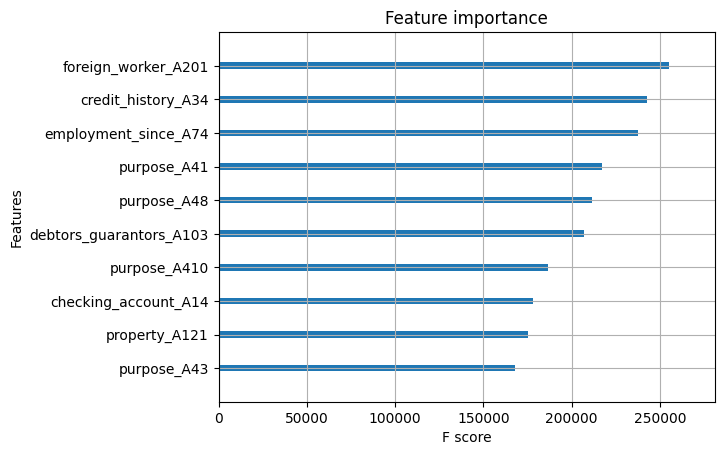

In [22]:
xgb.plot_importance(xgc, importance_type="cover", max_num_features=10, show_values=False);

ELI5 is another popular libarary for model explainability. This package is used to debug machine learning classifiers and explain their predictions. 

Unlike XGBoost, which is confined to explaining its own models only, ELI5 provides support for other frameworks like *scikit-learn*, *Keras*, *LightGBM* and others. It can also explain black-box models (i.e. Neural Networks) using [LIME](https://www.dominodatalab.com/blog/explaining-black-box-models-using-attribute-importance-pdps-and-lime).

First, ELI5 also provides a way of calculating the feature importance. Let's test it and make sure it agrees with the original XGBoost calculation (based on gain).

In [23]:
eli5.show_weights(xgc)

Weight,Feature
0.1011,checking_account_A14
0.0622,credit_history_A34
0.0611,property_A121
0.0393,checking_account_A13
0.0364,property_A122
0.0289,other_installments_A143
0.0275,debtors_guarantors_A103
0.0269,savings_A65
0.0259,purpose_A43
0.0221,savings_A61


A more interesting function is `show_predictions`, which returns an explanation of the decision behind individual predictions. In other words, we can see what features drove the model to predict one outcome or the other.

Feel free to experiment with the code below, changing the `id` value and observing what features the model uses to calculate its prediction, and if the prediction agrees with the actual value. The `id` variable represents an observation number from the test dataset.

In [24]:
id = 3 # <- change this to see results for different observations  

print("Actual Label: %s" % actuals.iloc[id])
print("Predicted: %s" % pred_class[id])
eli5.show_prediction(xgc, df_test_X.iloc[id], 
                     feature_names=list(df_test_X.columns),
                     show_feature_values=True)


Actual Label: 1
Predicted: 1


This concludes the model training notebook demo.

In [25]:
# Set some default values
column_names_all = ['duration', 'credit_amount', 'installment_rate', 'residence', 'age', 'credits', 'dependents', 'checking_account_A11', 'checking_account_A12', 'checking_account_A13', 'checking_account_A14', 'credit_history_A30', 'credit_history_A31',
                    'credit_history_A32', 'credit_history_A33', 'credit_history_A34', 'purpose_A40', 'purpose_A41', 'purpose_A410', 'purpose_A42', 'purpose_A43', 'purpose_A44', 'purpose_A45', 'purpose_A46', 'purpose_A48', 'purpose_A49', 'savings_A61', 
                    'savings_A62', 'savings_A63', 'savings_A64', 'savings_A65', 'employment_since_A71', 'employment_since_A72', 'employment_since_A73', 'employment_since_A74', 'employment_since_A75', 'status_A91', 'status_A92', 'status_A93', 'status_A94', 
                    'debtors_guarantors_A101', 'debtors_guarantors_A102', 'debtors_guarantors_A103', 'property_A121', 'property_A122', 'property_A123', 'property_A124', 'other_installments_A141', 'other_installments_A142', 'other_installments_A143', 'housing_A151', 
                    'housing_A152', 'housing_A153', 'job_A171', 'job_A172', 'job_A173', 'job_A174', 'telephone_A191', 'telephone_A192', 'foreign_worker_A201', 'foreign_worker_A202']

sample_data = [[0.4705882352941176, 0.3685484758446132, 0.3333333333333333, 0.3333333333333333, 
                0.2857142857142857, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 
                1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 
                1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 
                1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0]]

In [26]:
df_all = pd.DataFrame(sample_data, columns=column_names_all)

In [27]:
for col in ['checking_account_A11', 'checking_account_A12', 'checking_account_A13', 'checking_account_A14', 
                'credit_history_A30', 'credit_history_A31', 'credit_history_A32', 'credit_history_A33', 
                'credit_history_A34', 'purpose_A40', 'purpose_A41', 'purpose_A410', 'purpose_A42', 'purpose_A43', 
                'purpose_A44', 'purpose_A45', 'purpose_A46', 'purpose_A48', 'purpose_A49', 'savings_A61', 
                'savings_A62', 'savings_A63', 'savings_A64', 'savings_A65', 'employment_since_A71', 
                'employment_since_A72', 'employment_since_A73', 'employment_since_A74', 'employment_since_A75', 
                'status_A91', 'status_A92', 'status_A93', 'status_A94', 'debtors_guarantors_A101', 
                'debtors_guarantors_A102', 'debtors_guarantors_A103', 'property_A121', 'property_A122', 
                'property_A123', 'property_A124', 'other_installments_A141', 'other_installments_A142', 
                'other_installments_A143', 'housing_A151', 'housing_A152', 'housing_A153', 'job_A171', 'job_A172', 
                'job_A173', 'job_A174', 'telephone_A191', 'telephone_A192', 'foreign_worker_A201', 'foreign_worker_A202']:
    df_all[col] = df_all[col].astype('int')


In [28]:
eli5.show_prediction(xgc, df_all.iloc[0], 
                         feature_names=list(df_all.columns),
                         show_feature_values=True)

In [29]:
df_all.iloc[0]

duration               0.470588
credit_amount          0.368548
installment_rate       0.333333
residence              0.333333
age                    0.285714
                         ...   
job_A174               1.000000
telephone_A191         0.000000
telephone_A192         1.000000
foreign_worker_A201    1.000000
foreign_worker_A202    0.000000
Name: 0, Length: 61, dtype: float64

In [30]:
df_all.iloc[0]["checking_account_A14"]

0.0

In [31]:
df_prediction = eli5.explain_prediction_df(xgc, df_all.iloc[0], 
                         feature_names=list(df_all.columns))

In [32]:
df_prediction.head(10).style.background_gradient(cmap = "Greens").hide()

target,feature,weight,value
y,purpose_A41,1.025536,1.000000
y,credit_amount,0.471257,0.368548
y,age,0.367119,0.285714
y,status_A93,0.198880,1.000000
y,status_A92,0.153400,0.000000
y,job_A173,0.136513,0.000000
y,telephone_A192,0.134630,1.000000
y,checking_account_A11,0.125837,0.000000
y,employment_since_A73,0.119860,1.000000
y,property_A123,0.081924,1.000000
